# Exploring Determinants of Housing Prices in Melbourne Using Open Data

## Introduction: (need to be filled later)

Python version : 2.7

background of this project....

## Data Collection: Housing prices dataset

Instruction on how to download Housing prices datasets titled as **For sale, for rent and sold data by SA2 01/01/1986 - 31/12/2017** (Owned by Australian Property Monitors) from AURIN Portal

.......


## Loading Housing Prices Data (APM) from Downloaded packages
NOTE : At this moment, the study is only focusing on a single Housing prices dataset, which was updated at December, 2017 by APM. APM also provided mutiple Housing prices datasets from 1986 to 2017. Time series analysis on those datasets will be implemented later for improvements if possible. 

In [14]:
import json
import os

## S2Area is a class representing each area in victoria states. 
## attribute id: S2 code for a area  
## attribute dataDict: A dictionary whose key is a date, value is a dictionary storing dataset collected at that date. 
class S2Area:
    def __init__(self,id):
        self.id = id 
        self.dataDict = {}
        
    ## updateDataDict add a new dataset collected at Date, to a S2Area Object
    def updateDataDict(self, Date, datasetName, data):
        dataset = self.dataDict.get(Date, {})
        if not dataset.get(datasetName,None):
            dataset[datasetName] = data
            self.dataDict[Date] = dataset
        else:
            print "Dataset is been overwritten"
        

def openFile(filepath):
    with open(filepath,'r') as fp:
        data = json.load(fp)
    return data

## initialAreas returns 
## potential problem: Areas' name and size maybe different at different time dimension, need to double check dataset.
def initialAreas(data):
    areaList = []
    for feature in data['features']:
        properties = feature['properties']
        areaCode = properties['SA22011Code']
        medianPrice = properties['Sold_Both_Auction_Private_Treaty_MedianPrice']
        avgPrice = properties['For_Sale_Both_Auction_Private_Treaty_AveragePrice']
        if medianPrice and avgPrice:
            date = int(str(properties['DateMonth']) + str(properties['DateYear']))
            area = S2Area(id = areaCode)
            area.updateDataDict(Date = date, datasetName = "medianPrice", data = medianPrice)
            area.updateDataDict(Date = date, datasetName = "avgPrice", data = avgPrice)
            areaList.append(area)
    return areaList
data = openFile('./Prices/For_sale__for_rent_and_sold_data_by_SA2_01_01_1986_-_31_12_2017/data8915622582211247437.json')
areaList = initialAreas(data)
for item in areaList:
    print item.id, item.dataDict
        
    


206071139 {122017: {'medianPrice': 1270000.0, 'avgPrice': 1190340.0}}
210011226 {122017: {'medianPrice': 805000.0, 'avgPrice': 728825.3}}
206051128 {122017: {'medianPrice': 2150000.0, 'avgPrice': 2240139.0}}
204011054 {122017: {'medianPrice': 313500.0, 'avgPrice': 399196.0}}
201011001 {122017: {'medianPrice': 400500.0, 'avgPrice': 407735.5}}
206021110 {122017: {'medianPrice': 1500000.0, 'avgPrice': 1293158.0}}
213021341 {122017: {'medianPrice': 915000.0, 'avgPrice': 948937.1}}
213021342 {122017: {'medianPrice': 620000.0, 'avgPrice': 601103.9}}
213021343 {122017: {'medianPrice': 817000.0, 'avgPrice': 766705.2}}
215011386 {122017: {'medianPrice': 247000.0, 'avgPrice': 255185.9}}
215011387 {122017: {'medianPrice': 285000.0, 'avgPrice': 284926.8}}
213011328 {122017: {'medianPrice': 632000.0, 'avgPrice': 595143.4}}
206061135 {122017: {'medianPrice': 2105000.0, 'avgPrice': 2230179.0}}
206031113 {122017: {'medianPrice': 1150500.0, 'avgPrice': 1073576.0}}
207011146 {122017: {'medianPrice': 177

## Colleting Datasets of Neighbourhood Characteristics and Location Features for Each Area
Note: Datasets collected through AURIN API and AURIN Portal

### Register new dataset to areas

In [15]:
##Now the study is only focus on a single housing price dataset collected on DEC, 2017, 
##So we assume other collected Datasets of Neighbourhood Characteristics and Location Features 
##are collected at same year as housing price dataset.
##But this need to be modified later.
def registerDataset(featureValue, featureName, areaObject):
    areaObject.updateDataDict(Date = 122017, datasetName = featureName, data = featureValue)
    

## Data Collection Part A : AURIN API 

### Binding Credentials to URL Requests (modified from GEOT1D, to fit in python 2.7 environment)

In [4]:
import configparser
import urllib2
from urllib2 import Request, urlopen, URLError, HTTPError
from lxml import etree
config = configparser.RawConfigParser()
config.read('openapi.cfg')

username=config.get('Auth', 'username')
password=config.get('Auth', 'password')

def openapi_request(url):
    password_mgr = urllib2.HTTPPasswordMgrWithDefaultRealm()
    password_mgr.add_password(None, url, username, password)
    auth_manager = urllib2.HTTPBasicAuthHandler(password_mgr)
    opener = urllib2.build_opener(auth_manager)
    urllib2.install_opener(opener)
    req = urllib2.Request(url)
    try:
        response = urllib2.urlopen(req)
        return response.read()
    except urllib2.HTTPError as err:
        if err.code == 404:
            #When requesting the metadata by url, the server limits the successful times, so when
            #meeting HTTPError 404, print the message and request again.
            print ('Trying to access with url...')
            return openapi_request(url)
        else:
            raise
url = 'http://openapi.aurin.org.au/csw?request=GetCapabilities&service=CSW'
xml = openapi_request(url)
root = etree.fromstring(xml)
print ("------------------------------------------------------------------------")
print ("Get capabilities successfully.")
print ("------------------------------------------------------------------------")



------------------------------------------------------------------------
Get capabilities successfully.
------------------------------------------------------------------------


/Users/Edison/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


### Obtain Available Datasets from AURIN API 

In [5]:
url='http://openapi.aurin.org.au/csw?request=GetRecords&service=CSW&version=2.0.2&typeNames=csw:Record&elementSetName=full&resultType=results&constraintLanguage=CQL_TEXT&constraint_language_version=1.1.0&maxRecords=5000'
xml = openapi_request(url)
root = etree.fromstring(xml)
print '================ DATASETS ================'
print 'Query URL: '+url
#print etree.tostring(root, pretty_print=True)
aggregation = raw_input("Select area aggregation level. for example: sa2 ")
for dataset in root.findall(".//csw:Record", root.nsmap):
    #print etree.tostring(dataset, pretty_print=True)
    if 'sa2' in dataset.find(".//dc:title", root.nsmap).text:
        print '================ DATASET ================'
        print 'Dataset: '+dataset.find(".//dc:title", root.nsmap).text
#     print dataset.find(".//dc:rights", root.nsmap).text

================ DATASETS ================
Query URL: http://openapi.aurin.org.au/csw?request=GetRecords&service=CSW&version=2.0.2&typeNames=csw:Record&elementSetName=full&resultType=results&constraintLanguage=CQL_TEXT&constraint_language_version=1.1.0&maxRecords=5000
Select area aggregation level. for example: sa2 sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b01_aust_sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b02_aust_sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b03_aust_sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b04a_aust_sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b04b_aust_sa2
================ DATASET ================
Dataset: datasource-AU_Govt_ABS-UoM_AURIN_DB_1_b05_aust_sa2
================ DATASET ================
Dataset: datasource-AU_

Recommende DatasetName:
family income: datasource-AU_Govt_ABS-UoM_AURIN_DB_2_sa2_p26_total_family_income_by_composition_census_2016


In [6]:
from collections import defaultdict
def getFeatures(dataset):
    url = 'http://openapi.aurin.org.au/wfs?request=DescribeFeatureType&service=WFS&version=1.1.0&typeName='+dataset
    
    xml = openapi_request(url)
    root = etree.fromstring(xml)
    property_dict = defaultdict(list)
    for element in root.find(".//xsd:sequence", root.nsmap):
        property_name = element.get('name')
        value = element.get('name')
        property_dict[property_name] = None
        print property_name
print("This is a list of datasets may be interesting.....")
datasetName = raw_input("Enter a dataset Name to view features ")


getFeatures(datasetName)

This is a list of datasets may be interesting.....
Enter a dataset Name to view features datasource-AU_Govt_ABS-UoM_AURIN_DB_2_sa2_p26_total_family_income_by_composition_census_2016
sa2_name16
sa2_main16
neg_nil_inc_cpl_fam_no_child
neg_nil_inc_cpl_fam_wth_chld
neg_nil_inc_one_parent_fam
neg_nil_inc_other_fam
neg_nil_inc_tot
fi_1_149_cpl_fam_no_child
fi_1_149_cpl_fam_with_child
fi_1_149_one_parent_fam
fi_1_149_other_fam
fi_1_149_tot
fi_150_299_cpl_fam_no_child
fi_150_299_cpl_fam_with_child
fi_150_299_one_parent_fam
fi_150_299_other_fam
fi_150_299_tot
fi_300_399_cpl_fam_no_child
fi_300_399_cpl_fam_with_child
fi_300_399_one_parent_fam
fi_300_399_other_fam
fi_300_399_tot
fi_400_499_cpl_fam_no_child
fi_400_499_cpl_fam_with_child
fi_400_499_one_parent_fam
fi_400_499_other_fam
fi_400_499_tot
fi_500_649_cpl_fam_no_child
fi_500_649_cpl_fam_with_child
fi_500_649_one_parent_fam
fi_500_649_other_fam
fi_500_649_tot
fi_650_799_cpl_fam_no_child
fi_650_799_cpl_fam_with_child
fi_650_799_one_parent_fam

In [7]:
def getFeatureValue(name, prop):
    #This can get all values for property_name
    url = 'http://openapi.aurin.org.au/wfs?request=GetPropertyValue&service=WFS&version=2.0.0&TypeName='+name+'&valueReference='+prop
    
    xml = openapi_request(url)
    root = etree.fromstring(xml)

    values = []
    for member in root.findall('.//wfs:member',root.nsmap):
        value = member.find('.//aurin:'+prop,root.nsmap).text
        values.append(value) 
    return values
featureName = raw_input("Enter a feature name ")
# featureName = 'tot_tot'
    

Enter a feature name tot_tot


Convert other aggregation level to sa2

In [7]:
#Check for Aggregation 
#Ensure that the dataset is aggregated in one of the aggregations that we are able to analyse
#Find the aggregation 
def checkAggr(datasetname):
    """This function will check a name of a property to see if it suggests that it's geogrpahically classified"""
    
    if (("lga" in datasetname.lower()) :
        return "lga"
    elif ("sla" in datasetname.lower()):
        return "sla"
    elif ("post" in datasetname.lower()) :
        return  "postcode"
    elif ("sa1" in datasetname.lower()) :
        return  "sa1"
    elif (("sa2" in datasetname.lower()) :
        return  "sa2"
    elif ("sa3" in datasetname.lower()):
        return  "sa3"
    elif ("sa4" in datasetname.lower()):
        return  'sa4'
    return False

SyntaxError: invalid syntax (<ipython-input-7-98d00545f234>, line 7)

In [16]:
## Define the ranking of the different correspondances
def determineHigherAggr(aggr1, aggr2):
    """This function takes two aggregation levels and returns the higher aggregation level
    It will return False if the two aggregation levels are the same

    """
    if aggr1 == aggr2:
        return False
    

    
    ranking_list = ["sa1", "postcode", "sla", "sa2", "lga", "sa3", "sa4"]
    
    
    
    index1 = ranking_list.index(aggr1)
    index2 = ranking_list.index(aggr2)
    
    
    # return the higher ranked aggregation
    if index1 < index2:
        return aggr2
    else:
        return aggr1

In [19]:
determineHigherAggr("sa1","sa2")

'sa2'

In [17]:

def loadCorrespondanceFolder(aggr_level_from, aggr_level_to):
    """This function returns the name of the relevant folder that we need to open a correspondance file"""
    
    correspondance_folder = ""
    correspondance_file = ""
    
    for (dirpath, dirnames, filenames) in os.walk("./Correspondances/"):
        for name in dirnames:

            # first check if it's possible convert between the two aggr levels
            # checking if there is a correspondence file being able to convert between the two aggr levels
            if aggr_level_from in name.lower() and aggr_level_to in name.lower():
                correspondance_folder = name
                
                # split the file name
                mix_case = correspondance_folder.split("_")
                
                filename_list =[i.lower() for i in mix_case]

                # the correspondence file has the pattern of the aggregation it's converting from is alway listed in the title
                # before the aggregation level it's converting to
                index_from = filename_list.index(aggr_level_from)
                index_to = filename_list.index(aggr_level_to)

                
                if index_from > index_to:
                    continue
                else:
                    break
    
    
    return correspondance_folder

In [18]:
import xlrd

def getCorrespondances(aggr_level_from, aggr_level_to):
    """This function will return a dataset in the form of a dictionary
    of the amount of correspondance between two aggregation levels"""
    correspondance_folder = loadCorrespondanceFolder(aggr_level_from, aggr_level_to)
    print("Correspondance_folder is:", correspondance_folder)
    correspondance_file = "./Correspondances/" + correspondance_folder + "/"
    
    # find the excel file
    if correspondance_folder is not None:
        for (dirpath, dirnames, filenames) in os.walk("./Correspondances/" + correspondance_folder):
            correspondance_file += filenames[0]
            
            
    # e.g. [[the aggr code from],[the aggr code to],[the correspondance ratio]]
    values_to = [[],[],[]]
    
    # Load the excel file
    wb = xlrd.open_workbook(correspondance_file)
    
    
    # Most of the time the correspondance values as in Table 3
    # Load the right spreadsheet that we want
    sheet = wb.sheet_by_name('Table 3')
    
    max_row = sheet.nrows
    
    
    

    # the Aggr_level converting from is usually in Column B
    aggr_from_column = 0
    
    # the Aggr_level converting to is usually in Column C
    aggr_to_column = 2
    # The ratio of the match is on column E
    
    ratio_column = 4
    
    # All of the values start at 8
    starting_row = 7
    
    # Get the relevant values and load them into values_to dict
    for i in range(starting_row, max_row):
        aggr_from = sheet.cell(i,aggr_from_column).value
        aggr_to = sheet.cell(i,aggr_to_column).value
        aggr_ratio = sheet.cell(i, ratio_column).value
        try:
            values_to[0].append(int(aggr_from))
            values_to[1].append(int(aggr_to))
            values_to[2].append(aggr_ratio)
        except ValueError:
            continue

    return values_to

In [17]:
getCorrespondances("sa2","lga")

('Correspondance_folder is:', '1270055006_CG_SA2_2011_LGA_2011')


[[101011001,
  101011002,
  101011002,
  101011002,
  101011002,
  101011002,
  101011003,
  101011004,
  101011004,
  101011004,
  101011004,
  101011005,
  101011005,
  101011006,
  101011006,
  101011006,
  101021007,
  101021007,
  101021008,
  101021009,
  101021010,
  101021011,
  101021011,
  101021011,
  101021011,
  101021012,
  101031013,
  101031013,
  101031014,
  101031014,
  101031015,
  101031015,
  101031016,
  101041017,
  101041018,
  101041019,
  101041020,
  101041020,
  101041020,
  101041021,
  101041022,
  101041022,
  101041023,
  101041024,
  101041024,
  101041025,
  101041026,
  101041027,
  101041027,
  102011028,
  102011029,
  102011030,
  102011030,
  102011031,
  102011032,
  102011033,
  102011034,
  102011035,
  102011036,
  102011037,
  102011038,
  102011039,
  102011040,
  102011041,
  102011041,
  102011042,
  102011043,
  102021044,
  102021045,
  102021046,
  102021047,
  102021048,
  102021049,
  102021050,
  102021051,
  102021052,
  102021053,

In [19]:
import json
def openFile(filepath):
    with open(filepath,'r') as fp:
        data = json.load(fp)
    return data
data = openFile('./Prices/LGA_Number_of_Offences_in_Victoria_by_Offence_Type_2008_-_2017/data9085226716414796589.json')

def extractFeature(aurinData, aggregation_level, feature_name):
    features = {}
    for feature in data['features']:
        properties = feature['properties']     
        areaCode = int(properties[aggregation_level])
        featurevalue = properties[feature_name]
        features[areaCode] = featurevalue
    return features
# print extractFeature(data, 'lga_code', 'grand_total_offence_count')

def addNewFeature(correspondances, areaList, aurinData, feature_name, aggregation_level):
    newAreaList = []
    features = extractFeature(data, aggregation_level, feature_name)
    for area in areaList:
        index = correspondances[0].index(area.id)
        correspondance_aggregation = correspondances[1][index]
        registerDataset(features[correspondance_aggregation], feature_name, area)
        newAreaList.append(area)
    return newAreaList
correspondances = getCorrespondances("lga", "sa2")    
newAreaList = addNewFeature(correspondances, areaList, data, 'grand_total_offence_count', 'lga_code')

for item in newAreaList:
    print item.id, item.dataDict

('Correspondance_folder is:', '1270055006_CG_SA2_2011_LGA_2011')
206071139 {122017: {'grand_total_offence_count': 13179, 'medianPrice': 1270000.0, 'avgPrice': 1190340.0}}
210011226 {122017: {'grand_total_offence_count': 8630, 'medianPrice': 805000.0, 'avgPrice': 728825.3}}
206051128 {122017: {'grand_total_offence_count': 13206, 'medianPrice': 2150000.0, 'avgPrice': 2240139.0}}
204011054 {122017: {'grand_total_offence_count': 733, 'medianPrice': 313500.0, 'avgPrice': 399196.0}}
201011001 {122017: {'grand_total_offence_count': 12028, 'medianPrice': 400500.0, 'avgPrice': 407735.5}}
206021110 {122017: {'grand_total_offence_count': 15532, 'medianPrice': 1500000.0, 'avgPrice': 1293158.0}}
213021341 {122017: {'grand_total_offence_count': 6132, 'medianPrice': 915000.0, 'avgPrice': 948937.1}}
213021342 {122017: {'grand_total_offence_count': 6132, 'medianPrice': 620000.0, 'avgPrice': 601103.9}}
213021343 {122017: {'grand_total_offence_count': 6132, 'medianPrice': 817000.0, 'avgPrice': 766705.2}}

{u'23670': 11974, u'25150': 2318, u'20910': 4809, u'27630': 446, u'22110': 3912, u'26610': 2358, u'20260': 1297, u'26490': 1206, u'25060': 8630, u'22620': 10267, u'24330': 8339, u'24210': 5022, u'21270': 202, u'22170': 15340, u'26170': 1548, u'25430': 1234, u'22830': 8029, u'22750': 22336, u'21370': 3545, u'24250': 718, u'22670': 19059, u'20110': 397, u'26430': 616, u'22910': 865, u'24410': 8704, u'20660': 9727, u'27450': 8347, u'26810': 4116, u'21180': 17300, u'26700': 2488, u'26980': 8338, u'24900': 2071, u'24130': 2571, u'21890': 15532, u'22410': 1667, u'20830': 3782, u'25810': 1176, u'23110': 6132, u'25900': 13206, u'25710': 2685, u'24650': 10994, u'27070': 15710, u'25490': 687, u'21110': 7863, u'24970': 11209, u'20740': 2646, u'21830': 1075, u'26730': 3511, u'21670': 1233, u'24850': 4726, u'20570': 12028, u'24780': 6639, u'23270': 20704, u'23350': 477, u'21450': 6250, u'26260': 1293, u'25250': 13238, u'21010': 1301, u'23190': 2487, u'21610': 22629, u'23940': 362, u'25340': 11466, 

In [8]:
sa2IdList = [int(a) for a in getFeatureValue(datasetName,'sa2_main16')]
valueList = getFeatureValue(datasetName, featureName)
newAreaList = []
for area in areaList:
#     print type(area.id)
    if area.id in sa2IdList:
        index = sa2IdList.index(area.id)
        value = valueList[index]
        registerDataset(value, featureName, area)
        newAreaList.append(area)

for item in newAreaList:
    print item.id, item.dataDict
        

206071139 {122017: {'tot_tot': '1886', 'medianPrice': 1270000.0, 'avgPrice': 1190340.0}}
210011226 {122017: {'tot_tot': '2089', 'medianPrice': 805000.0, 'avgPrice': 728825.3}}
206051128 {122017: {'tot_tot': '3947', 'medianPrice': 2150000.0, 'avgPrice': 2240139.0}}
204011054 {122017: {'tot_tot': '1630', 'medianPrice': 313500.0, 'avgPrice': 399196.0}}
201011001 {122017: {'tot_tot': '3086', 'medianPrice': 400500.0, 'avgPrice': 407735.5}}
206021110 {122017: {'tot_tot': '2212', 'medianPrice': 1500000.0, 'avgPrice': 1293158.0}}
213021341 {122017: {'tot_tot': '3438', 'medianPrice': 915000.0, 'avgPrice': 948937.1}}
213021342 {122017: {'tot_tot': '5247', 'medianPrice': 620000.0, 'avgPrice': 601103.9}}
213021343 {122017: {'tot_tot': '3643', 'medianPrice': 817000.0, 'avgPrice': 766705.2}}
215011386 {122017: {'tot_tot': '1966', 'medianPrice': 247000.0, 'avgPrice': 255185.9}}
215011387 {122017: {'tot_tot': '815', 'medianPrice': 285000.0, 'avgPrice': 284926.8}}
213011328 {122017: {'tot_tot': '1839',

## Data Collection Part B : AURIN Portal

### Select Features from Target Datasets

## Analysis

Preprocessing data for statistical testing 

In [10]:
y = []
x = []
for item in newAreaList:
    y.append(int(item.dataDict[122017]['medianPrice']))
    x.append(int(item.dataDict[122017]['tot_tot']))

Statistical testing 

In [11]:
import numpy as np
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(x, y)

res = mod.fit()

print(res.summary())

print("The Pierson Correlation Coefficient is: ")
np.corrcoef(x, y)[0, 1]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     628.9
Date:                Tue, 31 Jul 2018   Prob (F-statistic):           2.85e-83
Time:                        16:50:54   Log-Likelihood:                -3582.1
No. Observations:                 390   AIC:                             7166.
Df Residuals:                     389   BIC:                             7170.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031      0.000     25.078      0.0

/Users/Edison/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


0.19014893006203934

In [ ]:
# # import pandas as pd
# # import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier  #GBM algorithm
# from sklearn import cross_validation, metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

# def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
#     #Fit the algorithm on the data
#     alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
#     #Predict training set:
#     dtrain_predictions = alg.predict(dtrain[predictors])
#     dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
#     #Perform cross-validation:
#     if performCV:
#         cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
#     #Print model report:
#     print "\nModel Report"
#     print "Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions)
#     print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob)
#     if performCV:
#     print "CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score))

#     #Print Feature Importance:
#     if printFeatureImportance:
#         feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
#         feat_imp.plot(kind='bar', title='Feature Importances')
#         plt.ylabel('Feature Importance Score')

# gbm0 = GradientBoostingClassifier(random_state=10)
# modelfit(gbm0, train, predictors)

## Prediction (if with sufficient time series datasets)

## Visualization

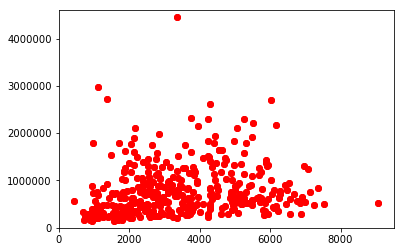

In [14]:
import matplotlib.pyplot as plt
plt.plot(x, y, 'ro')
plt.axis([0, max(x)+min(x), 0, max(y)+min(y)])
plt.show()

In [1]:
from bokeh.io import show, output_notebook, export_png
from bokeh.models import GeoJSONDataSource, ColumnDataSource, HoverTool, LinearColorMapper, LogColorMapper
from bokeh.palettes import Purples6 as palettex
from bokeh.plotting import figure, save

def drawLine(x,y,featurename, geo):
    # create a new plot with default tools, using figure
    title = "Correlation between number of patients and "+aurin_props[0]["name"]
    
    source = ColumnDataSource(data=dict(
    x=x,
    y=y,
    geo=geo
    ))
    
    hover = HoverTool(tooltips=[
        (geo_properties[0],'@geo'),
        ("Number of patients,", "$x"),
        (aurin_props[0]["name"], "$y")
    ])
    
    p = figure(title = title,plot_width=800, plot_height=400, tools=[hover], x_axis_label="Number of patients", y_axis_label=aurin_props[0]["name"])
    # add a circle renderer with a size, color, and alpha
    #p.line(x, y, line_width=2)
    p.circle("x", "y", line_color="navy", fill_color="blue", size=5, source=source)
    #
    # show the results
    output_notebook()
    show(p)
    
    export_png(p, filename="./Type2/"+featurename+ ".png")

ImportError: No module named bokeh.io

### For Code Testing